In [3]:
#---------Importing libraries---------#
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as T
import torchvision.datasets
import torch
import torch.nn as nn
from torchvision.utils import make_grid
from torchvision.utils import save_image
from torchinfo import summary

from tqdm.notebook import tqdm  # Progress bar
from IPython.display import Image
import matplotlib.pyplot as plt
import numpy as np
import random
import os
import pandas as pd
%matplotlib inline
import matplotlib_inline.backend_inline
from skimage import io
import splitfolders


matplotlib_inline.backend_inline.set_matplotlib_formats("svg", "pdf")  # For export

## Data processing

In [4]:
#current folder
current_path = os.getcwd()
current_path

'c:\\Users\\Usuario\\1 notebooks\\apziva\\document flip classifier\\page-flip-detector\\notebooks'

In [5]:
#go to parent folder to see the project path
project_path = os.path.abspath(os.path.join(current_path, os.pardir))
project_path

'c:\\Users\\Usuario\\1 notebooks\\apziva\\document flip classifier\\page-flip-detector'

In [6]:
#set the data paths
DATA_DIR = os.path.join(project_path, 'data')
DATA_DIR_RAW = os.path.join(DATA_DIR, 'raw')
DATA_DIR_PROCESSED = os.path.join(DATA_DIR, 'processed')
DATA_DIR_RAW_IMG = os.path.join(DATA_DIR_RAW, 'images')
DATA_DIR_RAW_IMG_TRAIN = os.path.join(DATA_DIR_RAW_IMG, 'training')


In [7]:
path = '../data/raw/images/testing/flip'


os.path.join(project_path, 'data\\raw\\preprocessed\\images\\training')  

'c:\\Users\\Usuario\\1 notebooks\\apziva\\document flip classifier\\page-flip-detector\\data\\raw\\preprocessed\\images\\training'

In [8]:
#splting the data into train and validation, run only once!
#splitfolders.ratio(DATA_DIR_RAW_IMG_TRAIN, output=DATA_DIR_PROCESSED , ratio=(0.8, 0.2)) # take the images of the training folder and split them into train and validation folders

# Data augmentation

## getting the mean and std of the normalized images

In [9]:
#getting the mean and std of the normalized images
import glob

images_path = os.path.join(DATA_DIR_RAW_IMG_TRAIN, 'flip')
images_files = [f for f in glob.glob(images_path + "**/*.jpg", recursive=True)]

#open the first image file
img = io.imread(images_files[0])
img.shape




(1920, 1080, 3)

In [10]:
def get_mean_std(images_path):
    """Get the mean and standard deviation of the images
    Args:
        images_path (str): path to the images folder

    Returns:
        mean (float): mean of the images
        std (float): standard deviation of the images"""
    
    images_files = [f for f in glob.glob(images_path + "**/*.jpg", recursive=True)]

    mean = np.zeros(3)
    stdTemp = np.zeros(3)
    std = np.zeros(3)
    nSamples = len(images_files)

    print('Calculating mean for each channel...')
    for i in tqdm(range(nSamples)):
        img = io.imread(images_files[i])
        img = img.astype(float)/255

        for j in range(3):
            mean[j] += img[:, :, j].mean()
        


    mean = mean/nSamples

    print('Calculating std for each channel...')
    for i in tqdm(range(nSamples)):
        img = io.imread(images_files[i])
        img = img.astype(float)/255

        for j in range(3):
            stdTemp[j] += ((img[:, :, j] - mean[j])**2).sum()/(img.shape[0]*img.shape[1])

    std = np.sqrt(stdTemp/(nSamples - 1))

    return mean, std




In [11]:
#calculating the mean and std of the images

# image_folder = os.path.join(DATA_DIR_RAW_IMG_TRAIN, 'flip')
# mean, std = get_mean_std(image_folder)
# print('mean: ', mean)
# print('std: ', std)

question: how to get the mean and std?

In [12]:
#creating transformation variables
mean = np.array([0.57647944, 0.52539918, 0.49818376])
std = np.array([0.21990674, 0.23702262, 0.24528695])

train_transform = T.Compose([
    T.Resize((224,224)), 
    T.RandomHorizontalFlip(),
    T.RandomRotation(10),
    T.ToTensor(),
    T.Normalize(mean=mean, std=std)
    
])

val_transform = T.Compose([
    T.Resize((224,224)),
    T.ToTensor()
    
])

test_transform = T.Compose([
    T.Resize((224,224)),
    T.ToTensor()
])



# Preparing data to train the model

In [13]:
#creating the datasets , with imagefolder to load the images even if they are in different folders.

train_dataset = torchvision.datasets.ImageFolder(root=os.path.join(DATA_DIR_PROCESSED, 'train'),
                                                  transform=train_transform)
val_dataset = torchvision.datasets.ImageFolder(root=os.path.join(DATA_DIR_PROCESSED, 'val'),
                                                    transform=val_transform)
test_dataset = torchvision.datasets.ImageFolder(root=os.path.join(DATA_DIR_RAW_IMG, 'testing'),
                                                    transform=test_transform)


In [14]:
#checking ou the classes and counts for each dataset

#training dataset
print('Train dataset classes: ', train_dataset.classes)
print('Train dataset classes labels: ', train_dataset.class_to_idx)
print('Train dataset classes counts: ', train_dataset.targets.count(0), train_dataset.targets.count(1))
print('Train dataset length: ', len(train_dataset))

print('\n----------------------------------\n')

#validation dataset
print('Validation dataset classes: ', val_dataset.classes)
print('Validation dataset classes labels: ', val_dataset.class_to_idx)
print('Validation dataset classes counts: ', val_dataset.targets.count(0), val_dataset.targets.count(1))
print('Validation dataset length: ', len(val_dataset))

print('\n----------------------------------\n')
#test dataset
print('Test dataset classes: ', test_dataset.classes)
print('Test dataset classes labels: ', test_dataset.class_to_idx)
print('Test dataset classes counts: ', test_dataset.targets.count(0), test_dataset.targets.count(1))
print('Test dataset length: ', len(test_dataset))

Train dataset classes:  ['flip', 'notflip']
Train dataset classes labels:  {'flip': 0, 'notflip': 1}
Train dataset classes counts:  929 984
Train dataset length:  1913

----------------------------------

Validation dataset classes:  ['flip', 'notflip']
Validation dataset classes labels:  {'flip': 0, 'notflip': 1}
Validation dataset classes counts:  233 246
Validation dataset length:  479

----------------------------------

Test dataset classes:  ['flip', 'notflip']
Test dataset classes labels:  {'flip': 0, 'notflip': 1}
Test dataset classes counts:  290 307
Test dataset length:  597


In [15]:
#creating our dataloader function

def get_data_loader(dataset, batch_size=16, shuffle=True):
    data_loader = torch.utils.data.DataLoader(dataset=dataset,
                                              batch_size=batch_size,
                                              shuffle=shuffle)
    return data_loader

question: How to choose batch size?

In [16]:
#showing transformed images
def show_transformed_images(dataset):
    loader = get_data_loader(dataset, batch_size=6, shuffle=True)
    batch = next(iter(loader))
    images, labels = batch

    grid = make_grid(images, nrow=3) # nrow is the number of images displayed in a row
    plt.figure(figsize=(10, 10))
    plt.imshow(grid.permute(1, 2, 0)) # permute to change the order of the channels from CxHxW to HxWxC
    plt.title('labels: {} \n where 0 is flipping and 1 is not fliping'.format(labels))
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


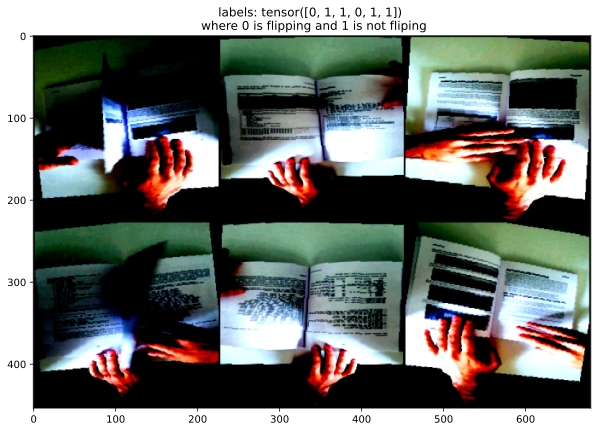

In [17]:
show_transformed_images(train_dataset)

In [18]:
#getting the dataloaders
train_loader = get_data_loader(train_dataset)
val_loader = get_data_loader(val_dataset, shuffle=False)
test_loader = get_data_loader(test_dataset, shuffle=False)

In [19]:
inputs, classes = next(iter(train_loader))

print(f'Batch size: {inputs.shape[0]}')
print(f'Number of color channels: {inputs.shape[1]}')
print(f'Image size: {inputs.shape[2]} x {inputs.shape[3]}')
print(f'Labels of the first batch: {classes}')
#print the shape of the target
print('Target shape: ', classes.shape)

Batch size: 16
Number of color channels: 3
Image size: 224 x 224
Labels of the first batch: tensor([1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1])
Target shape:  torch.Size([16])


# Checking device and setting deterministic options

In [20]:
print("Using torch", torch.__version__)

Using torch 2.1.0


In [21]:
torch.manual_seed(42)  # Setting the seed

In [22]:
gpu_avail = torch.cuda.is_available()
print(f"Is the GPU available? {gpu_avail}")

Is the GPU available? True


In [23]:
# Check device
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")


Using cuda device


In [24]:
if torch.cuda.is_available(): # GPU operations have a separate seed we also want to set
    torch.cuda.manual_seed(42)
    torch.cuda.manual_seed_all(42)

# Additionally, some operations on a GPU are implemented stochastic for efficiency
# We want to ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Creating a model

In [25]:
#convolutional neural network
#image shape = 224x224x3
#classes = 2

class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1), # 3 input channels, 32 kernerls, 3x3 kernel, stride of 1. Stride is the step size of the kernel
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), # 2x2 kernel, stride of 2. MaxPool2d is a downsampling operation

            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(64, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Flatten(), # Flatten the output of the previous layer to a vector
            #nn.linear input size: (Input Width + Kernel size + 2*Padding / Stride) + 1
            #input size = 224x224x3
            #after first conv2d layer = 224x224x32
            #after first maxpool2d layer = 112x112x32
            #after second conv2d layer = 112x112x64
            #after second maxpool2d layer = 56x56x64
            #after third conv2d layer = 56x56x32
            #after third maxpool2d layer = 28x28x32
            #after flatten layer = 28x28x32 = 25088
            
            nn.Linear(25088, 32),
            nn.ReLU(),
            nn.Dropout(0.1), # Dropout layer to reduce overfitting
            nn.Linear(32, 1) # 2 output classes
            
            
  
        )
        
    def forward(self, x):
        return self.model(x)
        







In [26]:
cnn_model = ConvNet().to(device)

import torchsummary
torchsummary.summary(cnn_model, (3, 224, 224))

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 1]                   --
|    └─Conv2d: 2-1                       [-1, 32, 224, 224]        896
|    └─ReLU: 2-2                         [-1, 32, 224, 224]        --
|    └─MaxPool2d: 2-3                    [-1, 32, 112, 112]        --
|    └─Conv2d: 2-4                       [-1, 64, 112, 112]        18,496
|    └─ReLU: 2-5                         [-1, 64, 112, 112]        --
|    └─MaxPool2d: 2-6                    [-1, 64, 56, 56]          --
|    └─Conv2d: 2-7                       [-1, 32, 56, 56]          18,464
|    └─ReLU: 2-8                         [-1, 32, 56, 56]          --
|    └─MaxPool2d: 2-9                    [-1, 32, 28, 28]          --
|    └─Flatten: 2-10                     [-1, 25088]               --
|    └─Linear: 2-11                      [-1, 32]                  802,848
|    └─ReLU: 2-12                        [-1, 32]                  --
|

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 1]                   --
|    └─Conv2d: 2-1                       [-1, 32, 224, 224]        896
|    └─ReLU: 2-2                         [-1, 32, 224, 224]        --
|    └─MaxPool2d: 2-3                    [-1, 32, 112, 112]        --
|    └─Conv2d: 2-4                       [-1, 64, 112, 112]        18,496
|    └─ReLU: 2-5                         [-1, 64, 112, 112]        --
|    └─MaxPool2d: 2-6                    [-1, 64, 56, 56]          --
|    └─Conv2d: 2-7                       [-1, 32, 56, 56]          18,464
|    └─ReLU: 2-8                         [-1, 32, 56, 56]          --
|    └─MaxPool2d: 2-9                    [-1, 32, 28, 28]          --
|    └─Flatten: 2-10                     [-1, 25088]               --
|    └─Linear: 2-11                      [-1, 32]                  802,848
|    └─ReLU: 2-12                        [-1, 32]                  --
|

As we can see, the nn size <40 MB, which means that it can be used in mobile applications.

In [27]:
#optimizer
optimizer = torch.optim.SGD(cnn_model.parameters(), lr=0.001, momentum=0.9)
loss_fn = nn.BCEWithLogitsLoss() # Binary cross entropy loss with logits ( no need to add sigmoid layer)

In [28]:
MODEL_DIR = os.path.join(project_path, 'models')

In [29]:
#creating a early stopping class

class EarlyStopping:
    def __init__(self, patience=5, delta=0, verbose=True, path=os.path.join(MODEL_DIR,'checkpoint.pt')):
        """
        Args:
            patience (int): Number of epochs with no improvement after which training will be stopped.
            delta (float): Minimum change in the monitored metric to be considered an improvement.
            verbose (bool): If True, prints a message for each improvement. 
            path (str): Path to save the best model checkpoint.
        """
        self.patience = patience
        self.delta = delta
        self.verbose = verbose
        self.path = path
        self.counter = 0
        self.best_metric = None
        self.early_stop = False

    def __call__(self, metric):
        """
        Args:
            metric (float): The metric to monitor (e.g., validation loss or accuracy).
        Returns:
            early_stop (bool): True if training should be stopped, False otherwise.
        """
        if self.best_metric is None:
            self.best_metric = metric
            self.save_checkpoint(metric)
        elif metric < self.best_metric - self.delta:
            self.best_metric = metric
            self.counter = 0
            self.save_checkpoint(metric)
        else:
            self.counter += 1
            if self.counter >= self.patience:
                if self.verbose:
                    print(f'Early stopping: No improvement in {self.patience} epochs.')
                self.early_stop = True

        return self.early_stop

    def save_checkpoint(self, metric):
        """
        Save the model checkpoint when the monitored metric improves.
        """
        if self.verbose:
            print(f'Metric improved ({self.best_metric:.6f} --> {metric:.6f}). Saving model...')
        torch.save(self.model.state_dict(), self.path)
        self.best_metric = metric


In [33]:
#TRAINING and validation loop

def train_loop(train_loader,  model, loss_fn, optimizer):
    train_size = len(train_loader.dataset)

    model.train()
    acc = 0
    

    print('Training...')

    for batch, (X, y) in enumerate(train_loader):
        X, y = X.to(device), y.to(device)

        #compute pred and loss
        pred = model(X).flatten()
        loss = loss_fn(pred, y.type(torch.float32))
        acc += (torch.round(pred) == y).type(torch.float32).mean().item()
        

        #brackprop
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 10 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f'loss: {loss:>7f} [{current:>5d}/{train_size:>5d}]')
            print(f'Accuracy: {acc:>7f}')

def val_loop(val_loader, model, loss_fn):
    
    print('Validating...')
    model.eval()
    acc = 0
    size = len(val_loader.dataset)
    num_batches = len(val_loader)
    test_loss, correct = 0, 0

    with torch.no_grad(): # No gradient calculation for validation
        for X, y in val_loader:
            X, y = X.to(device), y.to(device)
            
            #compute pred and loss
            pred = model(X).flatten()
            loss = loss_fn(pred, y.type(torch.float32))

            test_loss += loss.item()
            acc += (torch.round(pred) == y).type(torch.float32).mean().item()
        
    test_loss /= num_batches
    acc /= size
    
    print(f'Validation loss: {test_loss:>8f} \nAccuracy: {(correct)} \n')



In [34]:
for t in range(10):
    print(f'Epoch {t+1}\n-------------------------------')
    train_loop(train_loader, cnn_model, loss_fn, optimizer)
    val_loop(val_loader, cnn_model, loss_fn)

    if EarlyStopping(val_loop):
        break

Epoch 1
-------------------------------
Training...
loss: 0.661336 [   16/ 1913]
Accuracy: 0.500000
loss: 0.679334 [  176/ 1913]
Accuracy: 4.562500
loss: 0.633478 [  336/ 1913]
Accuracy: 9.250000
loss: 0.592616 [  496/ 1913]
Accuracy: 12.500000
loss: 0.545159 [  656/ 1913]
Accuracy: 18.062500
loss: 0.543983 [  816/ 1913]
Accuracy: 23.250000
loss: 0.658320 [  976/ 1913]
Accuracy: 26.562500
loss: 0.613504 [ 1136/ 1913]
Accuracy: 32.187500
loss: 0.572721 [ 1296/ 1913]
Accuracy: 37.250000
loss: 0.590222 [ 1456/ 1913]
Accuracy: 40.937500
loss: 0.570332 [ 1616/ 1913]
Accuracy: 44.562500
loss: 0.587469 [ 1776/ 1913]
Accuracy: 49.812500
Validating...
Validation loss: 0.702373 
Accuracy: 0 

